# Timeseries analysis of Reddit sentiment data and spy prices

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
import pandas as pd
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# import data
df = pd.read_csv('daily_sentiment.csv', parse_dates=['date'], index_col=False)
df

,spy,date,sent
0,269.115723,2018-08-10,-9.8812
1,267.804230,2018-08-15,-17.0701
2,271.501343,2018-08-20,-0.7095
3,271.615356,2018-08-23,5.1418
4,275.407410,2018-08-27,-3.4124
...,...,...,...
481,417.940002,2021-05-10,-26.9461
482,414.209991,2021-05-11,-5.6240
483,405.410004,2021-05-12,-32.2943
484,410.279999,2021-05-13,-0.2195


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   spy     486 non-null    float64       
 1   date    486 non-null    datetime64[ns]
 2   sent    486 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.5 KB


In [4]:
df.describe()

,spy,sent
count,486.000000,486.000000
mean,314.837299,-3.158943
std,48.482467,14.476494
min,219.431061,-43.698100
25%,275.836182,-12.657500
50%,304.966934,-3.286300
75%,352.475662,5.691575
max,422.119995,46.818000


### Reduce noise in the sentiment score with fourier transform

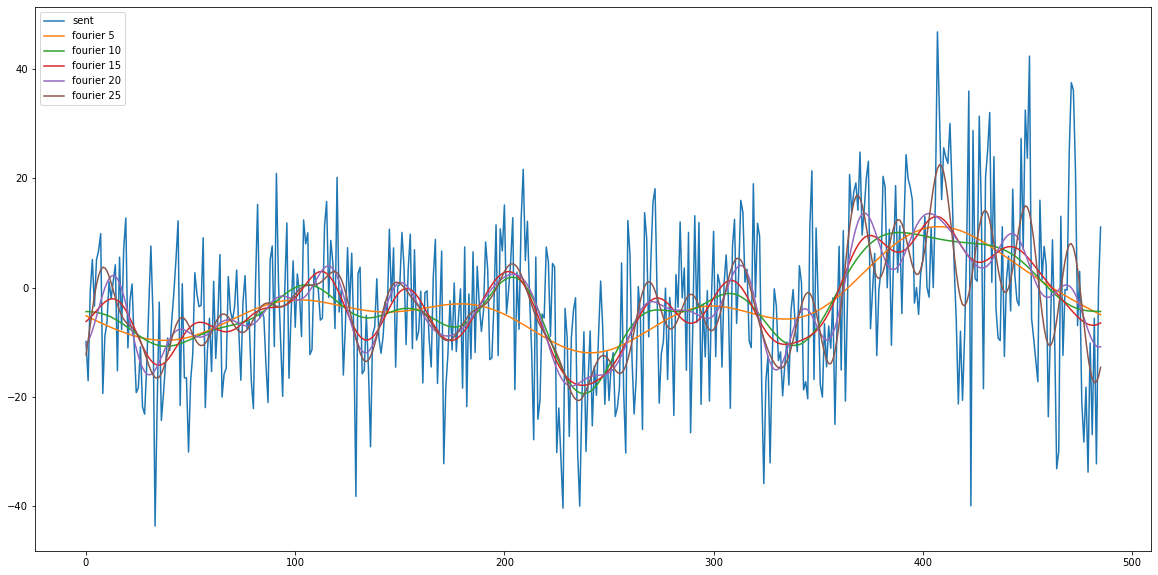

In [5]:
# extract sentiment score as a discrete fourier transform
price_fourier = np.fft.fft(np.asarray(df['sent'].tolist())) # convert sentiment to FFT with numpy
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array

for num_ in range(5,30,5):
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 # compund fourier to smoothen signal
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    df['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10) 
    
# plotting sentiment score and fourier transformed scores with different compounds
df[['sent', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25']].plot(figsize=(20, 10));


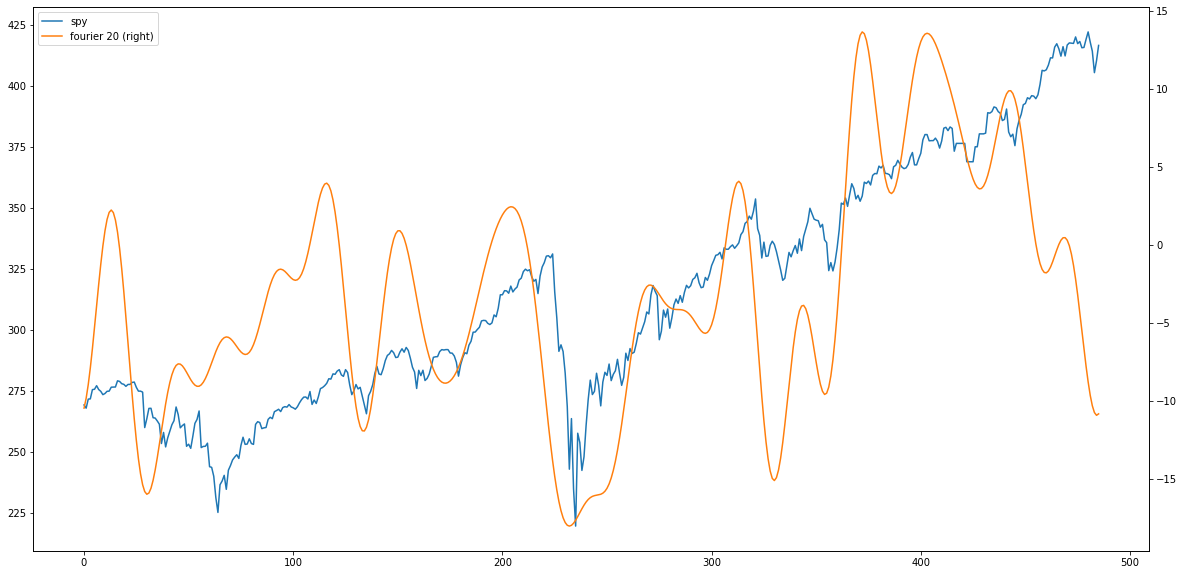

In [6]:
# plot price vs fourier 20
df[['spy', 'fourier 20', ]].plot(secondary_y='fourier 20', figsize=(20, 10));

In [7]:
# Prepare data, extracting year and month in seperate columns
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# export to csv
df.to_csv('timeseries.csv', index=False)

In [8]:
# Generate random colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

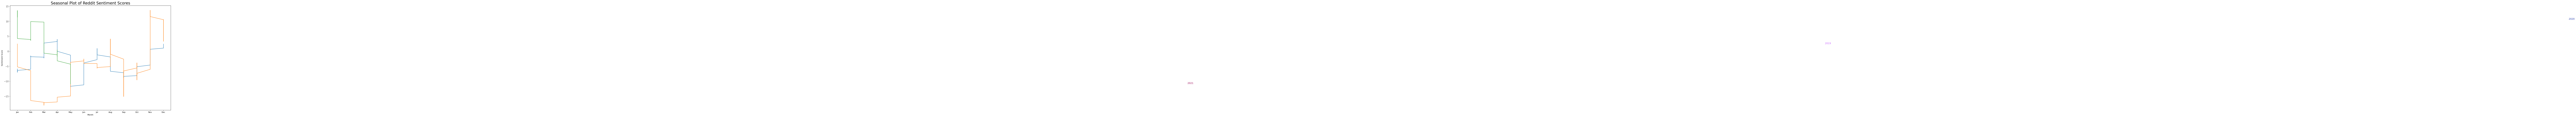

In [9]:
# Draw Plot
plt.figure(figsize=(15,10), dpi=80)

for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'fourier 20',data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'fourier 20'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        
plt.gca().set(ylabel='Sentiment Score', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Reddit Sentiment Scores", fontsize=20)
plt.show()        


#### The highest sentiment score generally appear in the end and the beginning of the year. 
A sharp decline happens in the summer months of june and july. This matches the general market behaviour, most professional traders and retail investors are on vacation some time over the summer, while bonusses get often paid out around the end of the year, leading to more people that invest

### Boxplot of seasonal score distribution

# Draw Plot

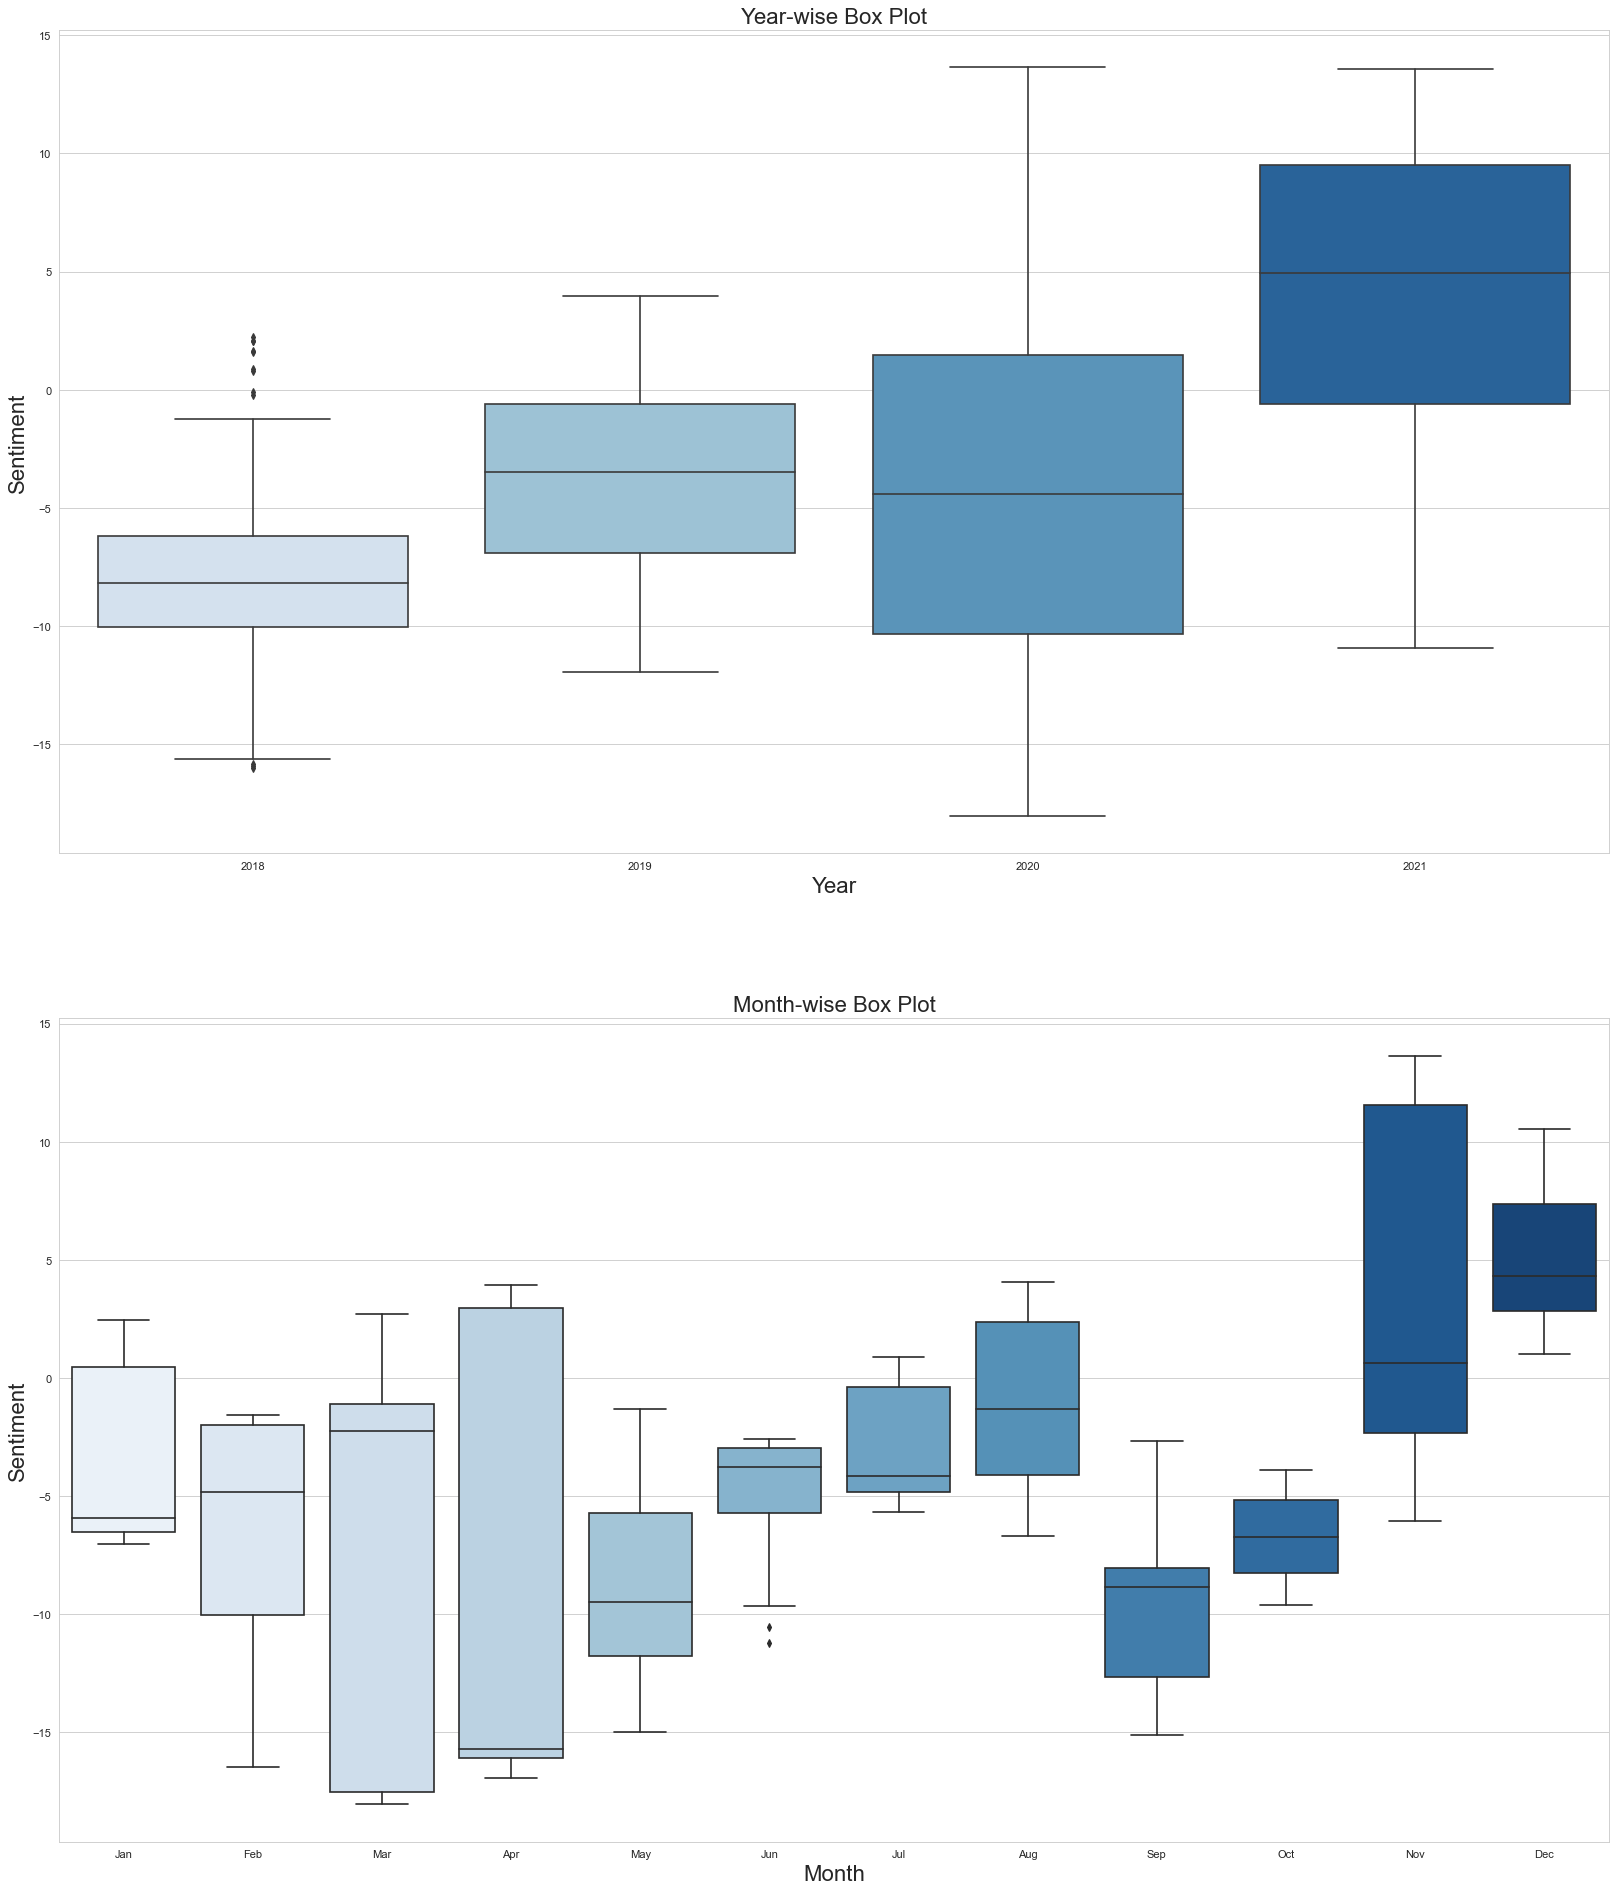

In [40]:
# Draw Plot
sn.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)
sn.color_palette("hls", 8)
sn.boxplot(x='year', y='fourier 20',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='month', y='fourier 20', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Year-wise Box Plot', fontsize=20); 
axes[1].set_title('Month-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

In [36]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(df.index.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.index.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

2021-05-15 21:07:51,535 [9438] WARNING  py.warnings:109: [JupyterRequire] /Users/ohmat/opt/anaconda3/envs/thamo/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(



ADF Statistic: 6.676908691226703
p-value: 1.0
Critial Values:
   1%, -3.4439615820186846
Critial Values:
   5%, -2.8675425624806605
Critial Values:
   10%, -2.5699671340268937

KPSS Statistic: 2.661642
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [33]:
df2

,spy,sent,fourier 5,fourier 10,fourier 15,fourier 20,fourier 25,year,month
date,,,,,,,,,
2018-08-10,269.115723,-9.8812,-5.176567+0.187373j,-4.404472+1.202116j,-6.213429-0.318905j,-10.477190+0.110770j,-12.354836+0.783686j,2018,Aug
2018-08-15,267.804230,-17.0701,-5.367095+0.069255j,-4.420860+1.241958j,-5.890956-0.056264j,-9.845790+0.019696j,-9.707922+0.404149j,2018,Aug
2018-08-20,271.501343,-0.7095,-5.555817-0.049152j,-4.443751+1.261070j,-5.522217+0.208487j,-8.973967-0.072687j,-6.893142-0.017240j,2018,Aug
2018-08-23,271.615356,5.1418,-5.742644-0.167354j,-4.475326+1.259133j,-5.117381+0.465421j,-7.896574-0.160238j,-4.120512-0.436845j,2018,Aug
2018-08-27,275.407410,-3.4124,-5.927475-0.284856j,-4.517610+1.236180j,-4.688277+0.704908j,-6.658712-0.237135j,-1.582551-0.811210j,2018,Aug
...,...,...,...,...,...,...,...,...,...
2021-05-10,417.940002,-26.9461,-4.199018+0.756511j,-4.336919+0.726576j,-6.911292-1.278717j,-9.657328+0.359056j,-16.698179+1.030670j,2021,May
2021-05-11,414.209991,-5.6240,-4.397703+0.647144j,-4.356652+0.853673j,-6.904576-1.160259j,-10.324481+0.350377j,-17.434043+1.241288j,2021,May
2021-05-12,405.410004,-32.2943,-4.594832+0.535075j,-4.370824+0.966523j,-6.830152-0.998304j,-10.760253+0.318402j,-17.294306+1.323361j,2021,May


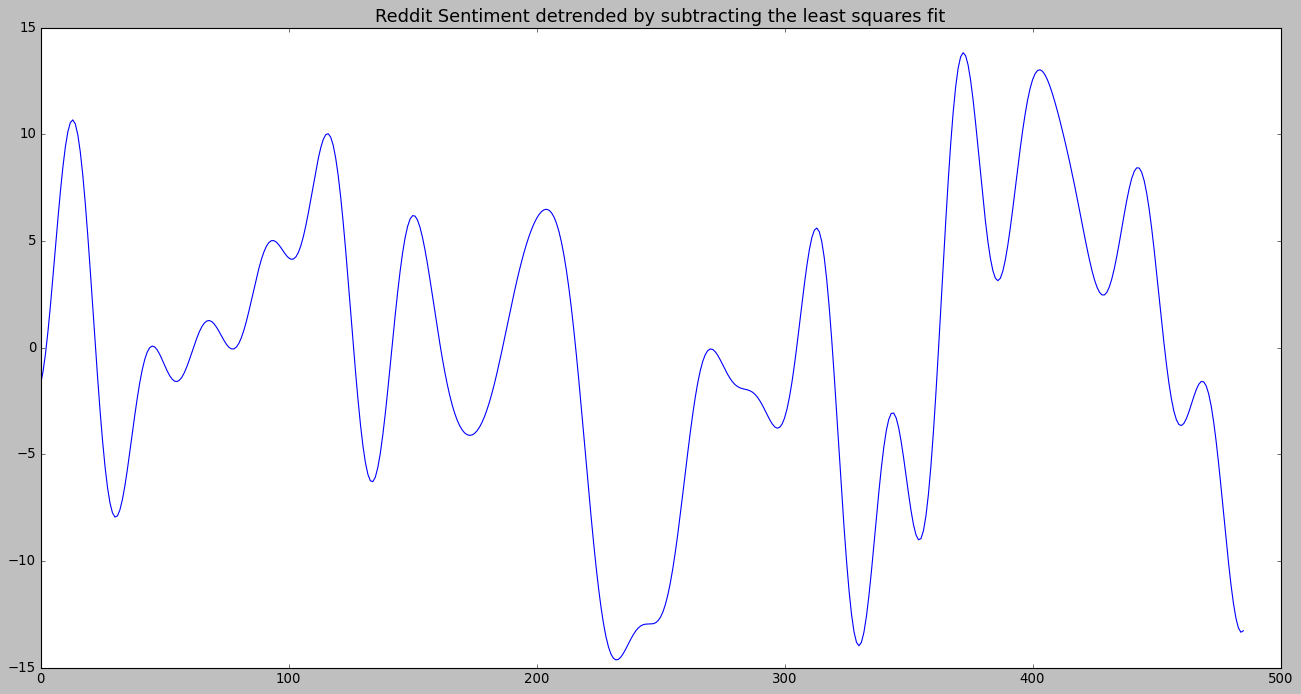

In [75]:
from scipy import signal
plt.figure(figsize=(20,10))
detrended = signal.detrend(df['fourier 20'].values)
#plt.style.use('classic')
plt.title('Reddit Sentiment detrended by subtracting the least squares fit', fontsize=16)
plt.plot(detrended);


In [79]:
# Subtracting the Trend Component.

# Time Series Decomposition
result_mul = seasonal_decompose(df['fourier 20'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df['fourier 20'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values